In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

In [2]:
df = pd.read_csv('results_micro.csv')
df.head()

,Unnamed: 0,model,type,accuracy,precision,recall,f1
0,0,7b_sft,none_conditioned,0.309533,0.309533,0.309533,0.309533
1,1,7b_sft,country_conditioned,0.308393,0.308393,0.308393,0.308393
2,2,7b_sft,value_conditioned,0.309533,0.309533,0.309533,0.309533
3,3,7b_sft,rot_conditioned,0.311052,0.311052,0.311052,0.311052
4,4,7b_sft_ppo,none_conditioned,0.331561,0.331561,0.331561,0.331561


In [3]:
models = df['model'].unique()


# Country

In [4]:
country_df = df[df['type'] == 'country_conditioned'].reset_index()
value_df = df[df['type'] == 'value_conditioned'].reset_index()
rot_df = df[df['type'] == 'rot_conditioned'].reset_index()

In [5]:
def get_grouped_stats(config_df: pd.DataFrame) -> pd.DataFrame:
    def map_model_name(model):
        if model.startswith('7b_sft'):
            return 'llama1-7b'
        elif model.startswith('13b_sft'):
            return 'llama1-13b'
        elif model.startswith('30b_sft'):
            return 'llama1-30b'
        else:
            return model

    def to_exclude(model):
        if model.endswith('ppo') or model.endswith('kto') or model.endswith('dpo'):
            return True
        else:
            return False

    config_df['grouped_model'] = config_df['model'].apply(map_model_name)
    config_df['exclude'] = config_df['model'].apply(to_exclude)
    order = [
    'llama1-7b', "llama1-13b", "llama1-30b", "llama2-7b-chat", "llama2-13b-chat",
        "llama2-70b-chat", "olmo-7b-sft", "olmo-7b-instruct", "mistral-chat",
        "gpt-3.5-turbo-0125", "gpt4"
    ]

    # Filter out dpo, ppo etc.
    # Only taking sft
    config_df = config_df[config_df['exclude'] == False ]

    # Apply the mapping function to the 'model' column
    config_df['grouped_model'] = pd.Categorical(config_df['grouped_model'], categories=order, ordered=True)

    # Group by the new 'grouped_model' column and calculate mean and standard deviation
    grouped_stats = config_df.groupby('grouped_model')['accuracy'].agg(['mean', 'std']).reset_index()
    grouped_stats['std'].fillna(0, inplace=True)
    grouped_stats['grouped_model'] = grouped_stats['grouped_model'].replace('gpt4', 'gpt-4').replace('gpt-3.5-turbo-0125', 'gpt-3.5-turbo').replace('mistral-chat', 'mistral-instruct').replace("llama1-7b", "llama1-7b-sft").replace("llama1-13b", "llama1-13b-sft").replace("llama1-30b", "llama1-30b-sft")

    # Convert the data to a DataFrame
    grouped_stats_df_config = pd.DataFrame(grouped_stats)
    return grouped_stats_df_config

In [6]:
grouped_stats_df_country = get_grouped_stats(country_df)
grouped_stats_df_value = get_grouped_stats(value_df)
grouped_stats_df_rot = get_grouped_stats(rot_df)

/tmp/ipykernel_197161/1275570625.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  config_df['grouped_model'] = pd.Categorical(config_df['grouped_model'], categories=order, ordered=True)
/tmp/ipykernel_197161/1275570625.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_stats = config_df.groupby('grouped_model')['accuracy'].agg(['mean', 'std']).reset_index()
/tmp/ipykernel_197161/1275570625.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will ch

In [7]:
from matplotlib.colors import to_rgba, to_hex

base_colors = {
    'llama1': '#ED5564',   # Red
    'llama2': '#FFCE54',   # Orange
    'olmo': '#A0D568',     # Dark green
    'mistral': '#4FC1E8',  # Teal
    'gpt': '#AC92EB'       # Purple
}


def set_color(grouped_stats_df_config) -> pd.DataFrame:
    '''
    adjust colors for base model
    '''
    def adjust_color_lightness(color, amount=0.5):
        """
        Adjusts a color's brightness.
        amount > 1.0 makes the color lighter, amount < 1.0 makes it darker.
        """
        try:
            c = to_rgba(color)
            c = (c[0] * amount, c[1] * amount, c[2] * amount, c[3])
            return to_hex(c)
        except Exception as e:
            print(f"Error adjusting color brightness: {e}")
            return color

    def get_model_base(name):
        """
        Extracts the base model name and adjusts for variations if necessary.
        """
        return name.split('-')[0]

    # Assign colors to each model, adjusting for specific variations
    # grouped_stats_df_value['color'] = grouped_stats_df_value['grouped_model'].apply(lambda x: get_model_base(x))
    grouped_stats_df_config['color'] = grouped_stats_df_config['grouped_model'].apply(lambda x: adjust_color_lightness(base_colors[get_model_base(x)],
                                                0.6 if '30' in x or '70' in x or 'olmo-7b-instruct' in x else (0.8 if '13b' in x or 'olmo-7b-instruct' in x or '4' in x else 1.2)))
    return grouped_stats_df_config

In [8]:
grouped_stats_df_country = set_color(grouped_stats_df_country)
grouped_stats_df_value = set_color(grouped_stats_df_value)
grouped_stats_df_rot = set_color(grouped_stats_df_rot)

Error adjusting color brightness: RGBA values should be within 0-1 range
Error adjusting color brightness: RGBA values should be within 0-1 range
Error adjusting color brightness: RGBA values should be within 0-1 range
Error adjusting color brightness: RGBA values should be within 0-1 range
Error adjusting color brightness: RGBA values should be within 0-1 range
Error adjusting color brightness: RGBA values should be within 0-1 range
Error adjusting color brightness: RGBA values should be within 0-1 range
Error adjusting color brightness: RGBA values should be within 0-1 range
Error adjusting color brightness: RGBA values should be within 0-1 range
Error adjusting color brightness: RGBA values should be within 0-1 range
Error adjusting color brightness: RGBA values should be within 0-1 range
Error adjusting color brightness: RGBA values should be within 0-1 range
Error adjusting color brightness: RGBA values should be within 0-1 range
Error adjusting color brightness: RGBA values shoul

In [9]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors


def plot_data(grouped_stats_df_config, config_name):
    # Create a figure and axis
    if config_name == 'rot':
        config_name = 'Rule-of-Thumb'
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot bars with error bars
    bars = ax.bar(grouped_stats_df_config['grouped_model'], grouped_stats_df_config['mean'], )
                #yerr=grouped_stats_df_value['std'].fillna(0).astype(float))

    # Set colors for each bar based on the group
    for i, model in enumerate(grouped_stats_df_config['grouped_model']):
        base_model = model.split('-')[0] # split by '-' and take the first part
        # Calculate color variant based on index and create a color gradient
        #color = mcolors.LinearSegmentedColormap.from_list(
        #    "grad", [mcolors.ColorConverter().to_rgba(base_colors[base_model], alpha=0.2),
        #             mcolors.ColorConverter().to_rgba(base_colors[base_model], alpha=1)], N=len(grouped_stats_df))(i)
        color = grouped_stats_df_value.iloc[i]['color']
        bars[i].set_color(color)

    # Set labels and title
    ax.set_ylabel('Accuracy', fontsize=36)
    ax.set_title(f'{config_name.title()} Accuracy', fontsize=36)

    # Add color legend
    for group, color in base_colors.items():
        ax.bar(0, 0, color=color, label=group)

    # add numbers over bars
    for i in range(len(grouped_stats_df_config)):
        ax.text(i, grouped_stats_df_config['mean'].iloc[i] + 0.02, f"{grouped_stats_df_config['mean'].iloc[i]:.2f}", ha='center', va='bottom', color='black', fontsize=24)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=16, ha='right')
    plt.ylim([0, 1])
    ax.yaxis.grid(True)
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
    # send the grid to back
    ax.set_axisbelow(True)
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    # ax.tick_params(axis='x', labelrotation=16, labelsize="large")

    # # hide x-ticks
    # ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)

    # add text underneath the first three bars to indicate the model size
    ax.text(1, -0.13, 'LLaMa1\n(7, 13, 30B)', ha='center', va='bottom', color='black', fontweight='bold', fontsize=20, rotation=0)
    ax.text(4, -0.13, 'LLaMa2\n(7, 13, 70B)', ha='center', va='bottom', color='black', fontweight='bold', fontsize=20, rotation=0)
    ax.text(6.5, -0.13, 'OLMo7b\n(SFT, Chat)', ha='center', va='bottom', color='black', fontweight='bold', fontsize=20, rotation=0)
    ax.text(8, -0.12, 'Mistral\n7b', ha='center', va='bottom', color='black', fontweight='bold', fontsize=20, rotation=0)
    ax.text(9.5, -0.15, 'GPT\n   (3.5turbo, 4)', ha='center', va='bottom', color='black', fontweight='bold', fontsize=20, rotation=0)
    # ax.text(10, -0.15, 'GPT-4', ha='center', va='bottom', color='black', fontweight='bold', fontsize=20, rotation=10)
    plt.axhline(y=0.33, color='grey', linestyle='--', linewidth=2.5, label='baseline reference')


    # Show plot
    plt.tight_layout()
    plt.savefig(f"{config_name}_conditioned.pdf", bbox_inches="tight")
    plt.show()


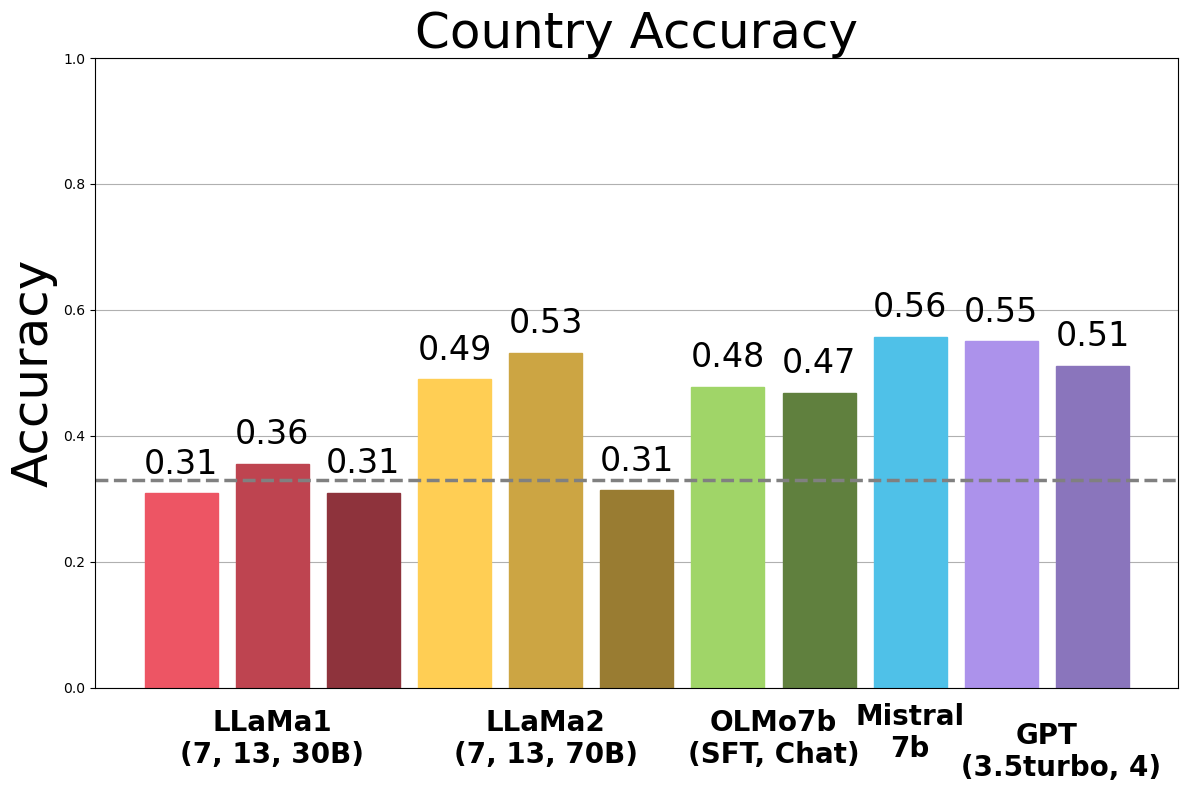

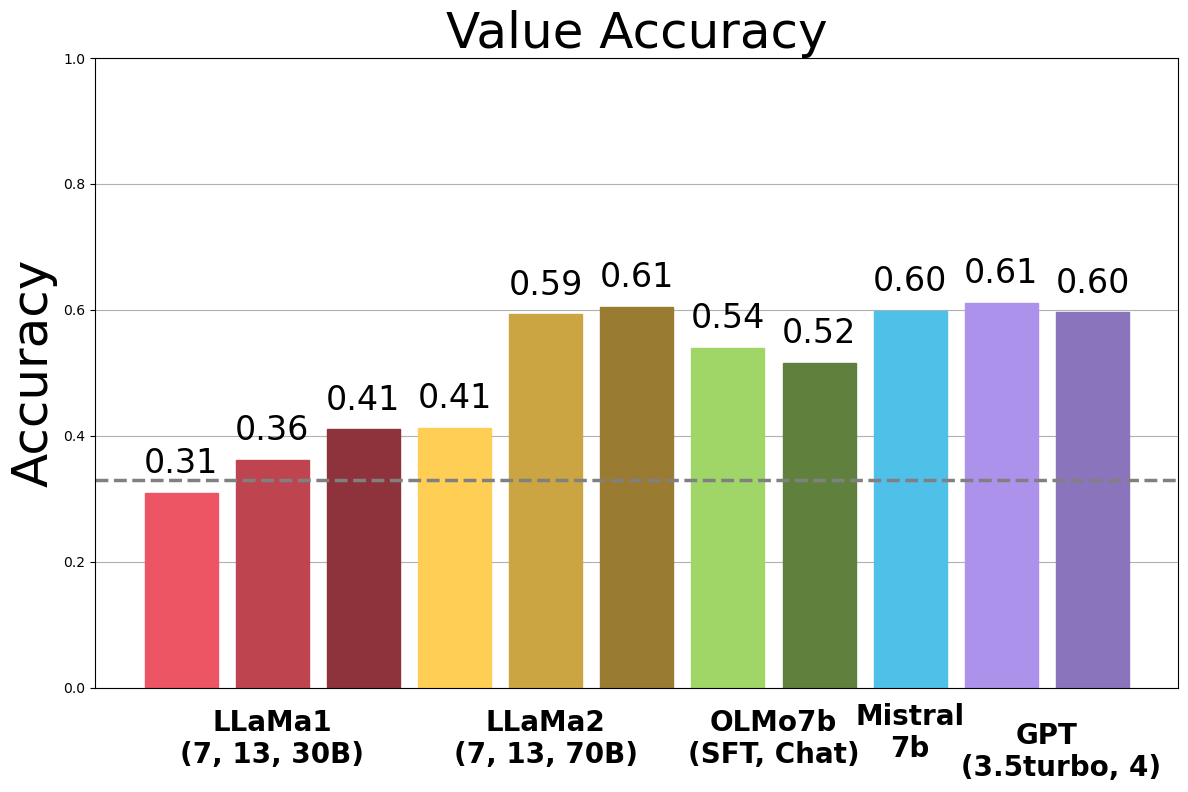

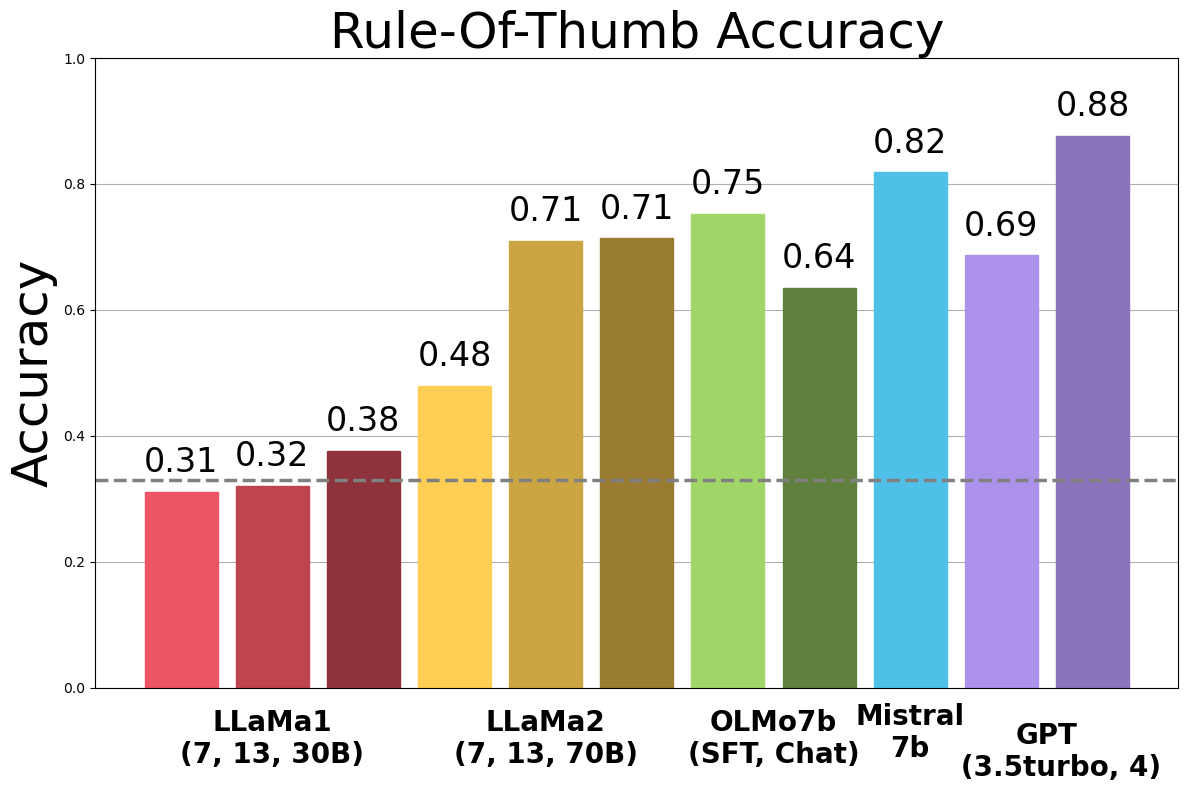

In [10]:
plot_data(grouped_stats_df_config=grouped_stats_df_country, config_name='country')
plot_data(grouped_stats_df_config=grouped_stats_df_value, config_name='value')
plot_data(grouped_stats_df_config=grouped_stats_df_rot, config_name='rot')